# Stock Market Informativeness of Iranian banking industry
## 
### banking course project - Fall 2021

#### Data Initialization

In [1]:
import os
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import statsmodels.formula.api as smf
import math
import jdatetime
import datetime
import pickle
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")

In [2]:
data_address = 'D:\Masters\Term3\Banking\Project\Data\Banks'
files = os.listdir(data_address)
all_raw = {}

for file in files:
    if file.endswith('.csv'):
        address = data_address + '\\' + file
        name = file.replace('-a.csv', '').replace('.csv', '').replace(' ', '_')
        all_raw[name] = pd.read_csv(address)

In [3]:
initial_dic = copy.deepcopy(all_raw)
deleted_banks = []
print('Proportion of open Days:')
for dataframe in initial_dic:
    proportion = round(100 * np.count_nonzero(initial_dic[dataframe]['<VOL>']) / len(initial_dic[dataframe]), 1)
    print(dataframe, ': ', proportion)
    if proportion <= 70:
        deleted_banks.append(dataframe)
for bank in deleted_banks:
        del initial_dic[bank]
print(initial_dic.keys())

Proportion of open Days:
Bank_of_M.E. :  95.2
Index_Group_57 :  99.5
Karafarin_Bank :  91.2
Overall_Index :  99.8
Parsian_Bank :  82.7
Post_Bank :  82.2
S_Mellat_Bank :  85.5
S_Pasargad_Bank :  74.1
S_Tejarat_Bank :  84.2
Saderat_Bank :  79.9
Sina_Fin._Ins. :  87.2
dict_keys(['Bank_of_M.E.', 'Index_Group_57', 'Karafarin_Bank', 'Overall_Index', 'Parsian_Bank', 'Post_Bank', 'S_Mellat_Bank', 'S_Pasargad_Bank', 'S_Tejarat_Bank', 'Saderat_Bank', 'Sina_Fin._Ins.'])


In [4]:
for bank in initial_dic:
    initial_dic[bank]['return_d'] = 0.0
    for i in range(1, len(initial_dic[bank])):
        initial_dic[bank]['return_d'][i] = 100 * (initial_dic[bank]['<CLOSE>'][i] - initial_dic[bank]['<CLOSE>'][i - 1]) / initial_dic[bank]['<CLOSE>'][i - 1]

overall_index = pd.DataFrame()
overall_index['date'] = pd.to_datetime(initial_dic['Overall_Index']['<DTYYYYMMDD>'], format='%Y%m%d')
overall_index['overall_close'] = initial_dic['Overall_Index']['<CLOSE>']
overall_index['overall_return_w'] = initial_dic['Overall_Index']['return_d']
overall_index['overall_value'] = initial_dic['Overall_Index']['<VALUE>']

bank_index = pd.DataFrame()
bank_index['date'] = pd.to_datetime(initial_dic['Index_Group_57']['<DTYYYYMMDD>'], format='%Y%m%d')
overall_index['industry_close'] = initial_dic['Index_Group_57']['<CLOSE>']
bank_index['industry_return_w'] = initial_dic['Index_Group_57']['return_d']
bank_index['industry_value'] = initial_dic['Index_Group_57']['<VALUE>']

#### SMI Measure No.1

***Stock return non-synchronicity (Roll 1988 JF)***

It equals $𝐿𝑛(\frac{1-𝑅^2}{𝑅^2})$ where $𝑅^2$ is calculated from estimating:
$$r_{i,j,t}=a_{i}+b_{i}r_{j,t}+c_{i}r_{m,t}+\epsilon_{i,j,t}$$
- $r_{i,j,t}$: return of firm *i* from industry *j* in week *t*.
- $r_{j,t}$: return of industry *j* in week *t* excluding firm *i*.
- $r_{m,t}$: return of market *m* in week *t* excluding firm *i*.

In [5]:
results_folder_m1 = r'D:\Masters\Term3\Banking\Project\Results\Measure_1'
tables_1 = open(results_folder_m1 + '\\tables_1.txt', 'a') #regression results for each bank over all periods
tables_1_y = open(results_folder_m1 + '\\tables_1_y.txt', 'a') #regression results for each bank at each year

banks = []
measure1 = []
measures_y = {}

for bank in initial_dic:
    if bank == 'Index_Group_57' or bank == 'Overall_Index':
        continue
    banks.append(bank)
    df = pd.DataFrame()
    df['date'] = pd.to_datetime(initial_dic[bank]['<DTYYYYMMDD>'], format='%Y%m%d')
    df['close'] = initial_dic[bank]['<CLOSE>']
    df['return_w'] = np.nan
    df['vol'] = initial_dic[bank]['<VOL>']
    df['value'] = initial_dic[bank]['<VALUE>']
    df = pd.merge(df, bank_index, how='left', on="date", suffixes=('', ''))
    df = pd.merge(df, overall_index, how='left', on="date", suffixes=('', ''))
    df['overall_close_r'] = 0.0
    df['overall_return_w_r'] = 0.0
    df['industry_close_r'] = 0.0
    df['industry_return_w_r'] = 0.0
    for i in range(len(df)):
        df.loc[i, 'overall_close_r'] = \
        df.loc[i, 'overall_close'] - (df.loc[i, 'close'] * df.loc[i, 'value'] / df.loc[i, 'overall_value'])
        df.loc[i, 'industry_close_r'] = \
        df.loc[i, 'industry_close'] - (df.loc[i, 'close'] * df.loc[i, 'value'] / df.loc[i, 'industry_value'])
    df['year'] = [df.loc[ii, 'date'].year for ii in range(len(df))]
    df['date_w'] =df['date']
    df = df.set_index('date')
    df_w = df.resample("W").last()
    year_w = df_w.columns.get_loc('year')
    return_w = df_w.columns.get_loc('return_w')
    close_w = df_w.columns.get_loc('close')
    overall_return_w_r = df_w.columns.get_loc('overall_return_w_r')
    overall_close_r = df_w.columns.get_loc('overall_close_r')
    industry_return_w_r = df_w.columns.get_loc('industry_return_w_r')
    industry_close_r = df_w.columns.get_loc('industry_close_r')
    for j in range(1, len(df_w)):
        df_w.iloc[j, return_w] = (df_w.iloc[j, close_w] - df_w.iloc[j - 1, close_w]) / df_w.iloc[j - 1, close_w]
        df_w.iloc[j, overall_return_w_r] = \
        100 * (df_w.iloc[j, overall_close_r] - df_w.iloc[j - 1, overall_close_r]) / df_w.iloc[j - 1, overall_close_r]
        df_w.iloc[j, industry_return_w_r] = \
        100 * (df_w.iloc[j, industry_close_r] - df_w.iloc[j - 1, industry_close_r]) / df_w.iloc[j - 1, industry_close_r]
    df_w.to_csv(results_folder_m1 + f'\\{bank}_1st_measure.csv')
    mod = smf.ols('return_w ~ overall_return_w_r + industry_return_w_r', data=df_w)
    res = mod.fit()
    summary = res.summary()
    measure1.append(math.log((1 - res.rsquared_adj) / res.rsquared_adj))
    tables_1.write(f'Bank: {bank} \n')
    tables_1.write(f'{str(summary)} \n')
    tables_1.write(f"{'-' * 100} \n")
#     print('Bank: ', bank)
#     print(summary)
#     print('-' * 100)
#     print('\n')
    start_years = int(df_w.iloc[0, year_w])
    final_years = int(df_w.iloc[-1, year_w])
    years = []
    m1_y = []
    for y in range(start_years, final_years + 1):
        df_y = pd.DataFrame(df_w[df_w['year'] == y])
        df_y = df_y.dropna().reset_index(drop=True)
        df_y = df_y.reset_index(drop=True)
        if len(df_y) < 30:
            continue
        years.append(y)
        mod_y = smf.ols('return_w ~ overall_return_w_r + industry_return_w_r', data=df_y)
        res_y = mod_y.fit()
        summary_y = res_y.summary()
        m1_y.append(math.log((1 - res_y.rsquared) / res_y.rsquared))
        tables_1_y.write(f'Bank: {bank} \n')
        tables_1_y.write(f'year: {y} \n')
        tables_1_y.write(f'{str(summary_y)} \n')
        tables_1_y.write(f"{'-' * 100} \n")
    measures_y[bank] = pd.DataFrame(columns = ['year', '1st_measure'])
    measures_y[bank]['year'] = years
    measures_y[bank]['1st_measure'] = m1_y
tables_1.close()
tables_1_y.close()

results_list = pd.DataFrame(banks, columns = ['bank'])
results_list['1st_measure'] = measure1

#### SMI Measure No.2

***Amihud illiquidity ratio (2002)***

$ILLIQ{i,y}=\frac{1}{D_{i,y}}\sum_{d=1}^{D_{i,y}}\frac{{|R_{i,y,d}|}}{VOLD_{i,y,d}}$

- $R_{i,y,d}$: the return of stock *i* in year *y* in day *d*.
- $VOLD_{i,y,d}$: the volume of trading (in Rials) of stock *i* in year *y* in day *d*.
- $D_{i,y}$: the number of days of available data on stock *i* in year *y*.

In [6]:
min_years = []
max_years = []

for bank in initial_dic:
    if bank == 'Index_Group_57' or bank == 'Overall_Index':
        continue
    date = pd.DataFrame()
    date['date'] = pd.to_datetime(initial_dic[bank]['<DTYYYYMMDD>'], format='%Y%m%d')
    date['year'] = pd.DatetimeIndex(date['date']).year
    min_years.append(np.min(date['year']))
    max_years.append(np.max(date['year']))

In [7]:
results_folder_2 = r'D:\Masters\Term3\Banking\Project\Results\Measure_2'

banks = []
measure2_df = pd.DataFrame()
measure2_df['year'] = list(range(np.min(min_years), np.max((max_years)) + 1))
measure2_df = measure2_df.set_index('year')
measure_2 = []

for bank in initial_dic:
    if bank == 'Index_Group_57' or bank == 'Overall_Index':
        continue
    measure2_df[bank] = np.nan
    banks.append(bank)
    df = pd.DataFrame()
    df['date'] = pd.to_datetime(initial_dic[bank]['<DTYYYYMMDD>'], format='%Y%m%d')
    df['close'] = initial_dic[bank]['<CLOSE>']
    df['return_d'] = initial_dic[bank]['return_d']
    df['vol'] = initial_dic[bank]['<VOL>']
    df['value'] = initial_dic[bank]['<VALUE>']
    df['year'] = pd.DatetimeIndex(df['date']).year
    df_nonzero = pd.DataFrame(df[[df.loc[i, 'value'] != 0 for i in range(len(df))]]).reset_index(drop=True)
    min_year = np.min(df_nonzero['year'])
    max_year = np.max(df_nonzero['year'])
    years = list(range(min_year, max_year + 1))
    measures_y[bank]['2nd_measure'] = np.nan
    #calculating Amihud's yearly illiquidity ratio for each bank:
    for y in years:
        df_branch = \
        pd.DataFrame(df_nonzero[[df_nonzero.loc[j, 'year'] == y for j in range(len(df_nonzero))]]).reset_index(drop=True)
        if len(df_branch) < 30:
            continue
        #illiquidity ratio for every 1000 Tomans (10k Rials):
        illiq = (1 / len(df_branch)) * np.sum(np.abs(10000 * df_branch['return_d']) / df_branch['value'])
        measure2_df.loc[y, bank] = illiq
        for yy in range(len(measures_y[bank]['year'])):
            if measures_y[bank].loc[yy, 'year'] == y:
                measures_y[bank].loc[yy, '2nd_measure'] = illiq
                break
    #calculating Amihud's total illiquidity ratio for each bank:
    illiq_t = (1 / len(df_branch)) * np.sum(np.abs(10000 * df_branch['return_d']) / df_branch['value'])
    measure_2.append(illiq_t)
results_list['2nd_measure'] = measure_2
measure2_df = measure2_df.reset_index()

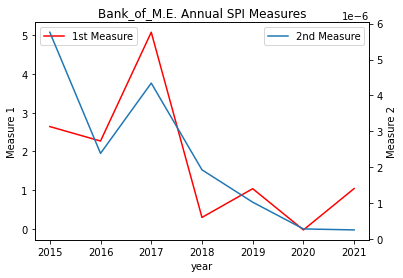

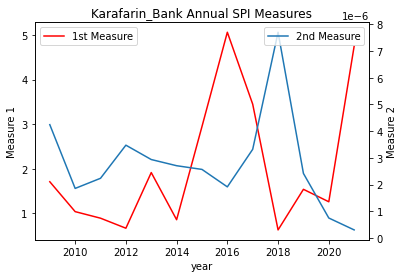

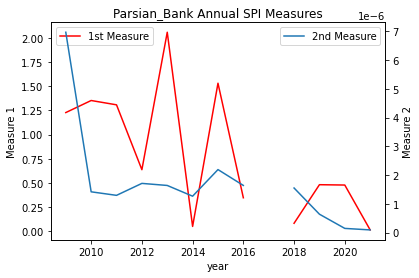

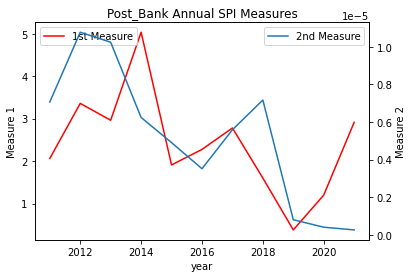

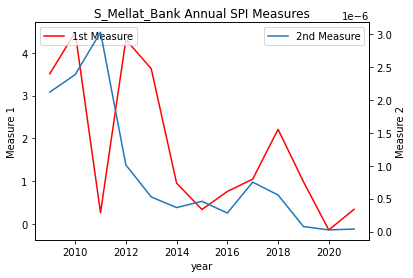

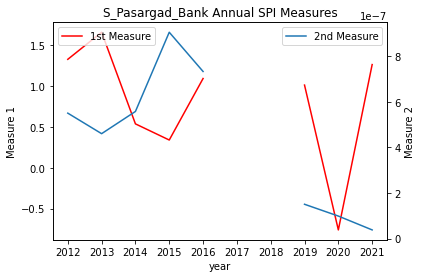

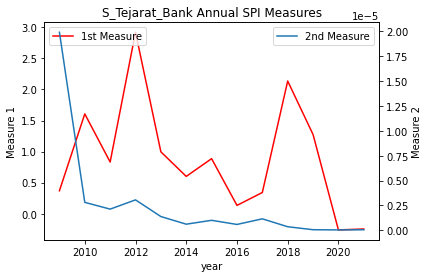

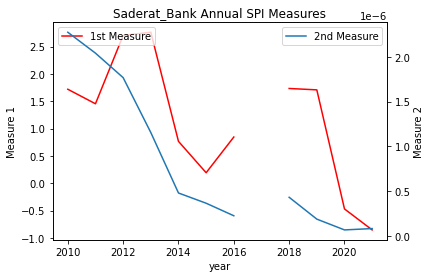

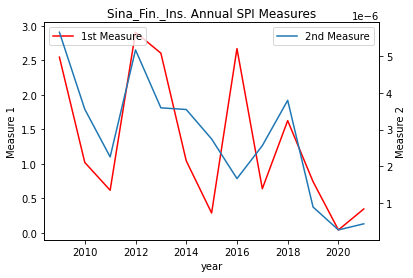

In [8]:
for bank in results_list['bank']:
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('year')
    ax1.set_ylabel('Measure 1')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.plot(measures_y[bank]['year'], measures_y[bank]['1st_measure'], color='red',label='1st Measure')
    ax1.legend(loc=2)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Measure 2')
    ax2.plot(measures_y[bank]['year'], measures_y[bank]['2nd_measure'], label='2nd Measure')
    ax2.legend(loc=1)
    plt.title(f'{bank} Annual SPI Measures')
    plt.savefig(results_folder_2 + f'\\{bank}_1stvs2nd_measure.png')
    plt.show()

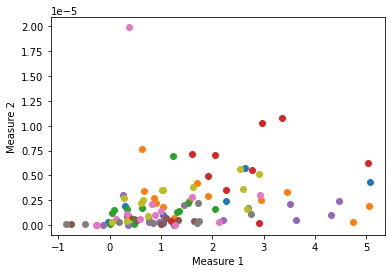

In [9]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Measure 1')
ax1.set_ylabel('Measure 2')
for bank in results_list['bank']:
    ax1.scatter(measures_y[bank]['1st_measure'], measures_y[bank]['2nd_measure'])
plt.show()

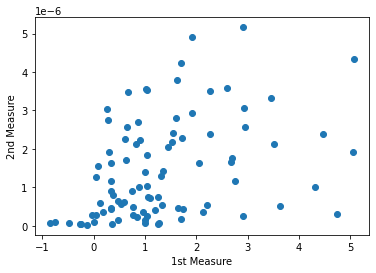

                                 GLS Regression Results                                
Dep. Variable:            2nd_measure   R-squared (uncentered):                   0.527
Model:                            GLS   Adj. R-squared (uncentered):              0.521
Method:                 Least Squares   F-statistic:                              86.90
Date:                Fri, 31 Dec 2021   Prob (F-statistic):                    2.56e-14
Time:                        14:54:18   Log-Likelihood:                          951.50
No. Observations:                  79   AIC:                                     -1901.
Df Residuals:                      78   BIC:                                     -1899.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [10]:
m_1 = []
m_2 = []
m1v2_i = pd.DataFrame()

for bank in results_list['bank']:
    for i in range(len(measures_y[bank])):
        m_1.append(measures_y[bank].loc[i, '1st_measure'])
        m_2.append(measures_y[bank].loc[i, '2nd_measure'])

m1v2_i['1st_measure'] = m_1
m1v2_i['2nd_measure'] = m_2

qh2 = m1v2_i["2nd_measure"].quantile(0.9)
ql2 = m1v2_i["2nd_measure"].quantile(0.1)
m1v2 = pd.DataFrame(m1v2_i[m1v2_i['2nd_measure'] < qh2])

plt.scatter(m1v2['1st_measure'], m1v2['2nd_measure'])
plt.xlabel('1st Measure')
plt.ylabel('2nd Measure')
plt.show()

m1v2 = m1v2[m1v2['2nd_measure'] > ql2].reset_index(drop=True)
mod_1v2 = sm.GLS(m1v2['2nd_measure'], m1v2['1st_measure'])
res_1v2 = mod_1v2.fit()
summary_1v2 = res_1v2.summary()
print(summary_1v2)

In [11]:
results_list

,bank,1st_measure,2nd_measure
0,Bank_of_M.E.,1.843570,2.546993e-07
1,Karafarin_Bank,2.001226,3.000202e-07
2,Parsian_Bank,0.690010,8.992139e-08
3,Post_Bank,2.719908,2.659309e-07
4,S_Mellat_Bank,1.491802,3.803368e-08
5,S_Pasargad_Bank,1.810723,3.777567e-08
6,S_Tejarat_Bank,0.869873,5.889360e-08
7,Saderat_Bank,0.717849,8.258254e-08
8,Sina_Fin._Ins.,0.979439,4.384202e-07


#### SMI Measures No.3 and 4

Two other measures are expressed from the regression below:
$$r_t = a + b_0 \Delta E_t + \sum _\tau b_\tau \Delta E_{t+\tau} + \sum _\tau c_\tau r_{t+\tau} + \varepsilon _t$$

where $\Delta E_t$ are changes in ***EBITDA*** devided by the market value of the equity in the beginning of the fiscal year, $\Delta E_{t+\tau}$ is the ***EPS*** change in $\tau$ periods ahead, and $r_{t+\tau}$ is the annual return of the stock at time $\tau$.

-Measure 3: 
$FERC = \sum b_\tau$

-Measure 4: 
$FINC = R^2_{r_t = a + b_0 \Delta E_t + \sum _\tau b_\tau \Delta E_{t+\tau} + \sum _\tau c_\tau r_{t+\tau} + \varepsilon _t}-R^2_{r_t = a + b_0 \Delta E_t + \varepsilon _t}$

In [12]:
data_address = 'D:\Masters\Term3\Banking\Project\Data'
high_r = []
low_r = []

for hindex in list(results_list['1st_measure'].nlargest(4).index):
    high_r.append(results_list.loc[hindex, 'bank'])
for lindex in list(results_list['1st_measure'].nsmallest(4).index):
    low_r.append(results_list.loc[lindex, 'bank'])

with open(data_address + '\\high_r.txt', 'wb') as fh:
    pickle.dump(high_r, fh)
with open(data_address + '\\low_r.txt', 'wb') as fl:
    pickle.dump(low_r, fl)

P.S.:

    Earnings per share have been collected semi-manually. Another option would be to use BeautifulSoup for web-scraping. However, due to the small size of needed data, the better option seemed to be the manual one.

In [13]:
eps_high_r = pd.read_csv(data_address + '\\eps_high_r.csv')
eps_high_r = eps_high_r.astype({'date' : 'datetime64',
                               'MV' : 'float',
                               'EBIT' : 'float'})

eps_low_r = pd.read_csv(data_address + '\\eps_low_r.csv')
eps_low_r = eps_low_r.astype({'date' : 'datetime64',
                              'MV' : 'float',
                             'EBIT' : 'float'})

In [14]:
# High "1st measure" firms:

eps_high_r['dE'] = np.nan
eps_high_r['EPS1'] = np.nan
eps_high_r['EPS2'] = np.nan
eps_high_r['EPS3'] = np.nan
eps_high_r['return0'] = np.nan
eps_high_r['return1'] = np.nan
eps_high_r['return2'] = np.nan
eps_high_r['return3'] = np.nan

for bank in high_r:
    df = pd.DataFrame(eps_high_r[eps_high_r['bank'] == bank])
    df_w = pd.read_csv(results_folder_m1 + f'\\{bank}_1st_measure.csv')
    df_w = df_w.astype({'date' : 'datetime64'})
    n = 0
    for i in list(df.index):
        curr_date = df.loc[i, 'date']
        ym1 = datetime.datetime(curr_date.year - 1, curr_date.month, curr_date.day)
        y1 = datetime.datetime(curr_date.year + 1, curr_date.month, curr_date.day)
        y2 = datetime.datetime(curr_date.year + 2, curr_date.month, curr_date.day)
        y3 = datetime.datetime(curr_date.year + 3, curr_date.month, curr_date.day)
        df_y0 = pd.DataFrame(df_w[df_w['date'] <= curr_date])
        df_y0 = pd.DataFrame(df_y0[df_y0['date'] >= ym1]).reset_index(drop=True)
        df_y1 = pd.DataFrame(df_w[df_w['date'] <= y1])
        df_y1 = pd.DataFrame(df_y1[df_y1['date'] >= curr_date]).reset_index(drop=True)
        df_y2 = pd.DataFrame(df_w[df_w['date'] <= y2])
        df_y2 = pd.DataFrame(df_y2[df_y2['date'] >= y1]).reset_index(drop=True)
        df_y3 = pd.DataFrame(df_w[df_w['date'] <= y3])
        df_y3 = pd.DataFrame(df_y3[df_y3['date'] >= y2]).reset_index(drop=True)
        if n > 0:
            eps_high_r.loc[i, 'dE'] = (eps_high_r.loc[i, 'EBIT'] - eps_high_r.loc[i - 1, 'EBIT']) / eps_high_r.loc[i, 'MV']
        if len(df_y0) != 0:
            eps_high_r.loc[i, 'return0'] = 100 * (list(df_y0['close'])[-1] - df_y0.loc[0, 'close']) / df_y0.loc[0, 'close']
            curr_price = df_y0.loc[0, 'close']
            if i <= list(df.index)[-1] - 3:
                eps_high_r.loc[i, 'EPS1'] = (eps_high_r.loc[i + 1, 'EPS'] - eps_high_r.loc[i, 'EPS']) / curr_price
                eps_high_r.loc[i, 'EPS2'] = (eps_high_r.loc[i + 2, 'EPS'] - eps_high_r.loc[i + 1, 'EPS']) / curr_price
                eps_high_r.loc[i, 'EPS3'] = (eps_high_r.loc[i + 3, 'EPS'] - eps_high_r.loc[i + 2, 'EPS']) / curr_price
        if len(df_y1) != 0:
            eps_high_r.loc[i, 'return1'] = 100 * (list(df_y1['close'])[-1] - df_y1.loc[0, 'close']) / df_y1.loc[0, 'close']
        if len(df_y2) != 0:
            eps_high_r.loc[i, 'return2'] = 100 * (list(df_y2['close'])[-1] - df_y2.loc[0, 'close']) / df_y2.loc[0, 'close']
        if len(df_y3) != 0:
            eps_high_r.loc[i, 'return3'] = 100 * (list(df_y3['close'])[-1] - df_y3.loc[0, 'close']) / df_y3.loc[0, 'close']
        n += 1

In [15]:
# Regression without EPS and future annual returns for calculating FINC:
eps_high_r = eps_high_r.dropna()
mod_high_e = smf.ols('return0 ~ dE', data=eps_high_r)
res_high_e = mod_high_e.fit()
summary_high_e = res_high_e.summary()
print(summary_high_e)

                            OLS Regression Results                            
Dep. Variable:                return0   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     5.179
Date:                Fri, 31 Dec 2021   Prob (F-statistic):             0.0391
Time:                        14:54:35   Log-Likelihood:                -83.718
No. Observations:                  16   AIC:                             171.4
Df Residuals:                      14   BIC:                             173.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.6375     12.477      1.333      0.2

In [16]:
# Regression of high "1st measure" firms without future stock returns as controls:
mod_high = smf.ols('return0 ~ dE + EPS1 + EPS2 + EPS3', data=eps_high_r)
res_high = mod_high.fit()
summary_high = res_high.summary()
print(summary_high)

                            OLS Regression Results                            
Dep. Variable:                return0   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     1.341
Date:                Fri, 31 Dec 2021   Prob (F-statistic):              0.315
Time:                        14:54:36   Log-Likelihood:                -83.058
No. Observations:                  16   AIC:                             176.1
Df Residuals:                      11   BIC:                             180.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.5602     15.471      1.006      0.3

In [17]:
# Regression of high "1st measure" firms with 3 future stock returns as controls:
mod_high_c = smf.ols('return0 ~ dE + EPS1 + EPS2 + EPS3 + return1 + return2 + return3', data=eps_high_r)
res_high_c = mod_high_c.fit()
summary_high_c = res_high_c.summary()
print(summary_high_c)

                            OLS Regression Results                            
Dep. Variable:                return0   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     1.194
Date:                Fri, 31 Dec 2021   Prob (F-statistic):              0.401
Time:                        14:54:37   Log-Likelihood:                -80.514
No. Observations:                  16   AIC:                             177.0
Df Residuals:                       8   BIC:                             183.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.7865     21.936      0.492      0.6

In [18]:
ferc_h = res_high.params['EPS1'] + res_high.params['EPS2'] + res_high.params['EPS3']
ferc_h_c = res_high_c.params['EPS1'] + res_high_c.params['EPS2'] + res_high_c.params['EPS3']

finc_h = res_high.rsquared - res_high_e.rsquared
finc_h_c = res_high_c.rsquared - res_high_e.rsquared

In [19]:
# Low "1st measure" firms:

eps_low_r['dE'] = np.nan
eps_low_r['EPS1'] = np.nan
eps_low_r['EPS2'] = np.nan
eps_low_r['EPS3'] = np.nan
eps_low_r['return0'] = np.nan
eps_low_r['return1'] = np.nan
eps_low_r['return2'] = np.nan
eps_low_r['return3'] = np.nan

for bank in low_r:
    df = pd.DataFrame(eps_low_r[eps_low_r['bank'] == bank])
    df_w = pd.read_csv(results_folder_m1 + f'\\{bank}_1st_measure.csv')
    df_w = df_w.astype({'date' : 'datetime64'})
    n = 0
    for i in list(df.index):
        curr_date = df.loc[i, 'date']
        ym1 = datetime.datetime(curr_date.year - 1, curr_date.month, curr_date.day)
        y1 = datetime.datetime(curr_date.year + 1, curr_date.month, curr_date.day)
        y2 = datetime.datetime(curr_date.year + 2, curr_date.month, curr_date.day)
        y3 = datetime.datetime(curr_date.year + 3, curr_date.month, curr_date.day)
        df_y0 = pd.DataFrame(df_w[df_w['date'] <= curr_date])
        df_y0 = pd.DataFrame(df_y0[df_y0['date'] >= ym1]).reset_index(drop=True)
        df_y1 = pd.DataFrame(df_w[df_w['date'] <= y1])
        df_y1 = pd.DataFrame(df_y1[df_y1['date'] >= curr_date]).reset_index(drop=True)
        df_y2 = pd.DataFrame(df_w[df_w['date'] <= y2])
        df_y2 = pd.DataFrame(df_y2[df_y2['date'] >= y1]).reset_index(drop=True)
        df_y3 = pd.DataFrame(df_w[df_w['date'] <= y3])
        df_y3 = pd.DataFrame(df_y3[df_y3['date'] >= y2]).reset_index(drop=True)
        if n > 0:
            eps_low_r.loc[i, 'dE'] = (eps_low_r.loc[i, 'EBIT'] - eps_low_r.loc[i - 1, 'EBIT']) / eps_low_r.loc[i, 'MV']
        if len(df_y0) != 0:
            eps_low_r.loc[i, 'return0'] = 100 * (list(df_y0['close'])[-1] - df_y0.loc[0, 'close']) / df_y0.loc[0, 'close']
            curr_price = df_y0.loc[0, 'close']
            if i <= list(df.index)[-1] - 3:
                eps_low_r.loc[i, 'EPS1'] = (eps_low_r.loc[i + 1, 'EPS'] - eps_low_r.loc[i, 'EPS']) / curr_price
                eps_low_r.loc[i, 'EPS2'] = (eps_low_r.loc[i + 2, 'EPS'] - eps_low_r.loc[i + 1, 'EPS']) / curr_price
                eps_low_r.loc[i, 'EPS3'] = (eps_low_r.loc[i + 3, 'EPS'] - eps_low_r.loc[i + 2, 'EPS']) / curr_price
        if len(df_y1) != 0:
            eps_low_r.loc[i, 'return1'] = 100 * (list(df_y1['close'])[-1] - df_y1.loc[0, 'close']) / df_y1.loc[0, 'close']
        if len(df_y2) != 0:
            eps_low_r.loc[i, 'return2'] = 100 * (list(df_y2['close'])[-1] - df_y2.loc[0, 'close']) / df_y2.loc[0, 'close']
        if len(df_y3) != 0:
            eps_low_r.loc[i, 'return3'] = 100 * (list(df_y3['close'])[-1] - df_y3.loc[0, 'close']) / df_y3.loc[0, 'close']
        n += 1

In [20]:
# Regression without EPS and future annual returns for calculating FINC:
eps_low_r = eps_low_r.dropna()
mod_low_e = smf.ols('return0 ~ dE', data=eps_low_r)
res_low_e = mod_low_e.fit()
summary_low_e = res_low_e.summary()
print(summary_low_e)

                            OLS Regression Results                            
Dep. Variable:                return0   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                    0.6027
Date:                Fri, 31 Dec 2021   Prob (F-statistic):              0.451
Time:                        14:54:41   Log-Likelihood:                -81.703
No. Observations:                  15   AIC:                             167.4
Df Residuals:                      13   BIC:                             168.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.6150     16.749      0.693      0.5

In [21]:
# Regression of low "1st measure" firms without future stock returns as controls:
mod_low = smf.ols('return0 ~ dE + EPS1 + EPS2 + EPS3', data=eps_low_r)
res_low = mod_low.fit()
summary_low = res_low.summary()
print(summary_low)

                            OLS Regression Results                            
Dep. Variable:                return0   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     3.898
Date:                Fri, 31 Dec 2021   Prob (F-statistic):             0.0369
Time:                        14:54:42   Log-Likelihood:                -74.995
No. Observations:                  15   AIC:                             160.0
Df Residuals:                      10   BIC:                             163.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -23.6807     16.037     -1.477      0.1

In [22]:
# Regression of low "1st measure" firms with 3 future stock returns as controls:
mod_low_c = smf.ols('return0 ~ dE + EPS1 + EPS2 + EPS3 + return1 + return2 + return3', data=eps_low_r)
res_low_c = mod_low_c.fit()
summary_low_c = res_low_c.summary()
print(summary_low_c)

                            OLS Regression Results                            
Dep. Variable:                return0   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     7.130
Date:                Fri, 31 Dec 2021   Prob (F-statistic):            0.00947
Time:                        14:54:43   Log-Likelihood:                -66.327
No. Observations:                  15   AIC:                             148.7
Df Residuals:                       7   BIC:                             154.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -55.4164     15.279     -3.627      0.0

In [23]:
ferc_l = res_low.params['EPS1'] + res_low.params['EPS2'] + res_low.params['EPS3']
ferc_l_c = res_low_c.params['EPS1'] + res_low_c.params['EPS2'] + res_low_c.params['EPS3']

finc_l = res_low.rsquared - res_low_e.rsquared
finc_l_c = res_low_c.rsquared - res_low_e.rsquared

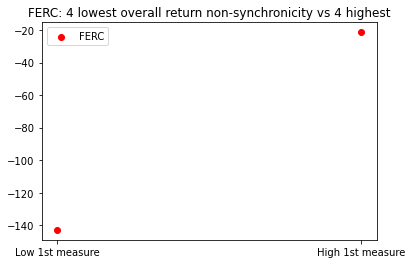

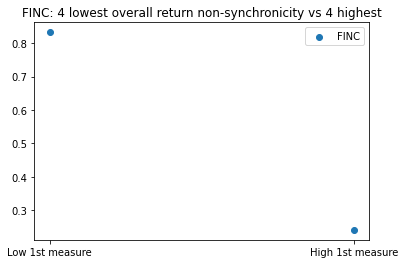

In [24]:
results_folder_3 = r'D:\Masters\Term3\Banking\Project\Results\Measure_3'

plt.scatter(['Low 1st measure', 'High 1st measure'], [ferc_l_c, ferc_h_c], label='FERC', color='red')
plt.title('FERC: 4 lowest overall return non-synchronicity vs 4 highest')
plt.legend()
plt.savefig(results_folder_3 + '\\FERC.png')
plt.show()
plt.scatter(['Low 1st measure', 'High 1st measure'], [finc_l_c, finc_h_c], label='FINC')
plt.title('FINC: 4 lowest overall return non-synchronicity vs 4 highest')
plt.legend()
plt.savefig(results_folder_3 + '\\FINC.png')
plt.show()